# 1. Import Required Libraries

In [104]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Set random seed for reproducibility
np.random.seed(42)


# Import additional libraries for hyperparameter tuning
from sklearn.metrics import precision_score, recall_score, classification_report
import optuna
from optuna.samplers import TPESampler


# xgBoost
import xgboost as xgb

# Suppress Optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 2. Load Data set

In [105]:
# Sourcecode found @ https://archive.ics.uci.edu/dataset/186/wine+quality
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 
  
# metadata 
print(wine_quality.metadata) 
  
# variable information 
print(wine_quality.variables) 


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

# 3. Data Preparation

<mark style="background-color: #fff000;">Item 1. Split the samples into 70% Training and 30% Testing data at random with stratification 
(stratify=y)</mark>

In [106]:
# Prompt: check if some cells are empty

In [107]:
# Split the dataset into training and testing sets(30% test size, 70% train size), stratified by the target variable
# Split first via color of the wine, then combine both colors after splitting
X_red =  wine_quality.data["original"][wine_quality.data["original"]['color'] == 'red'].drop(columns=['quality', 'color'])
y_red = wine_quality.data["original"][wine_quality.data["original"]['color'] == 'red']['quality']
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    X_red, y_red, test_size=0.3, stratify=y_red, random_state=42
)

X_white =  wine_quality.data["original"][wine_quality.data["original"]['color'] == 'white'].drop(columns=['quality', 'color'])
y_white = wine_quality.data["original"][wine_quality.data["original"]['color'] == 'white']['quality']
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split(
    X_white, y_white, test_size=0.3, stratify=y_white, random_state=42
)

# Combine the splits
X_train = pd.concat([X_train_red, X_train_white])
y_train = pd.concat([y_train_red, y_train_white])
X_test = pd.concat([X_test_red, X_test_white])
y_test = pd.concat([y_test_red, y_test_white])

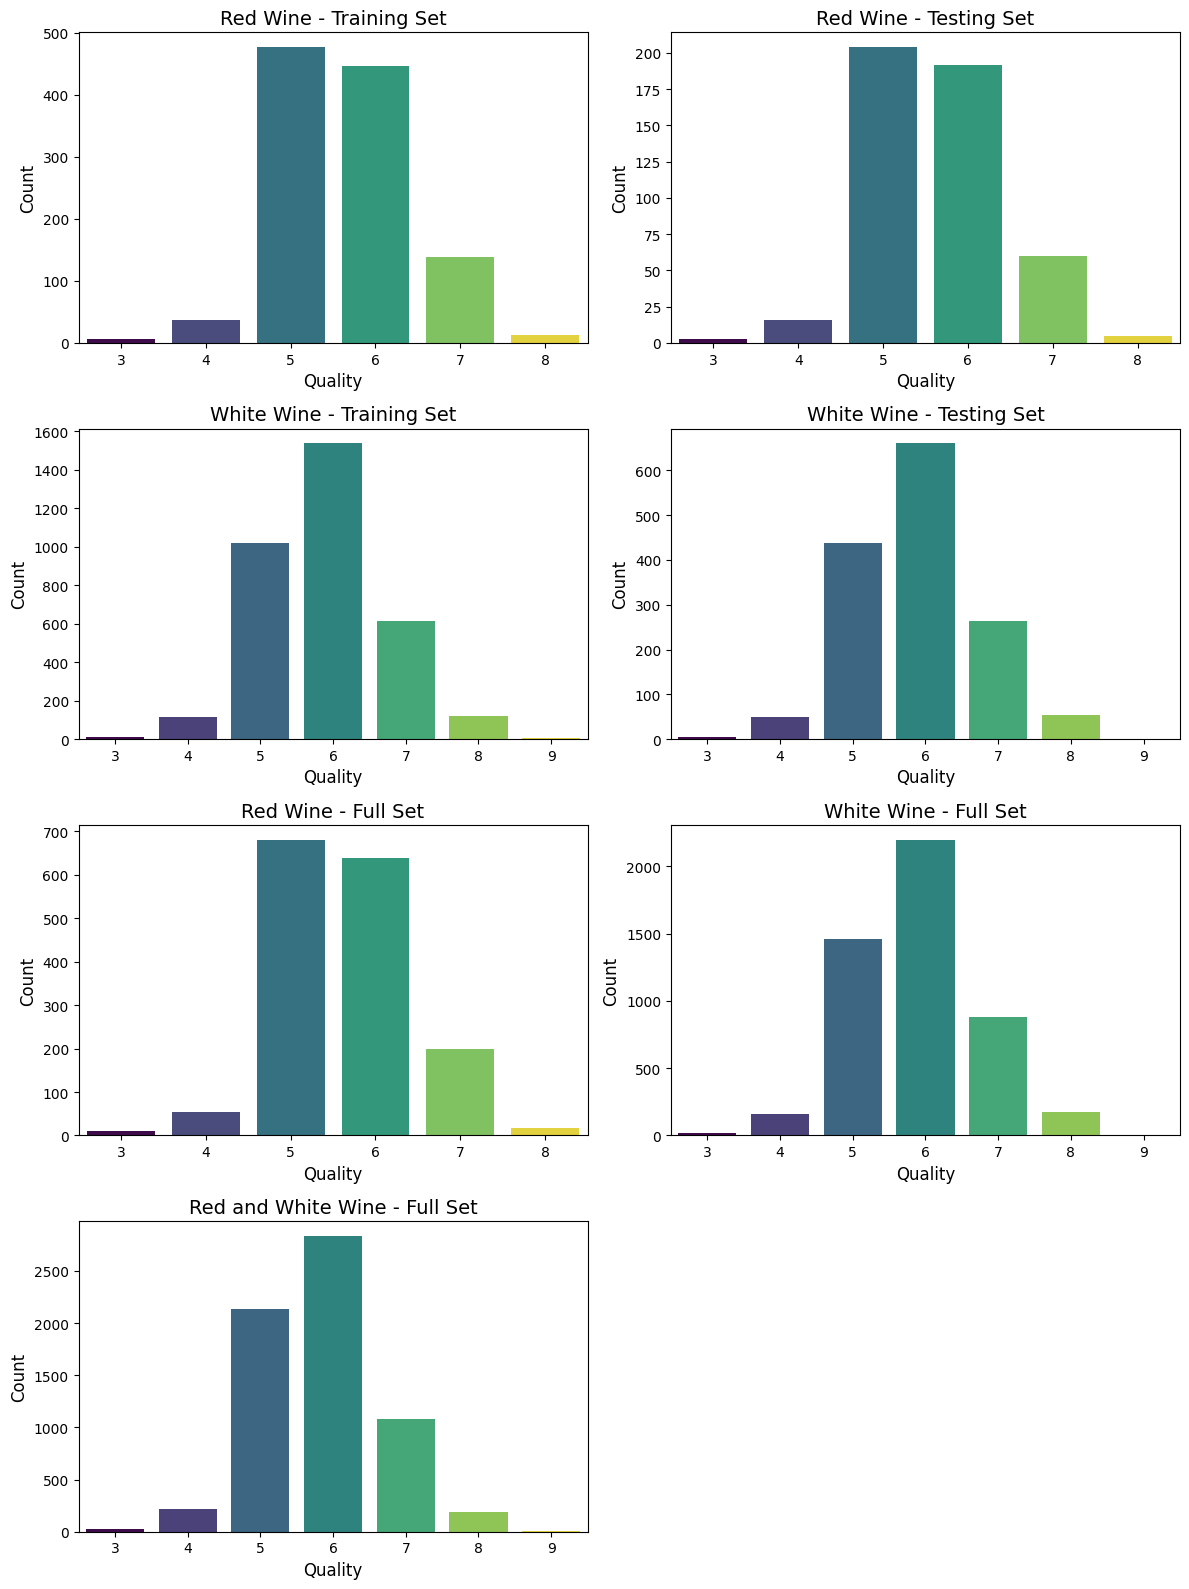

In [108]:
def plot_target_distribution(dataframes, titles):
    """
    Plots the distribution of the target variable for multiple dataframes.

    Parameters:
        dataframes (list of pd.DataFrame): List of dataframes to plot.
        titles (list of str): Corresponding titles for the dataframes.

    Returns:
        None
    """
    num_plots = len(dataframes)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()

    for i, (df, title) in enumerate(zip(dataframes, titles)):
        ax = axes[i]
        sns.countplot(x='quality', data=df, ax=ax, palette='viridis', hue='quality', legend=False)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Quality', fontsize=12)
        ax.set_ylabel('Count', fontsize=12)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage
# Ensure the dataframes contain the 'quality' column
plot_target_distribution(
    [
        pd.DataFrame({'quality': y_train_red}),
        pd.DataFrame({'quality': y_test_red}),
        pd.DataFrame({'quality': y_train_white}),
        pd.DataFrame({'quality': y_test_white}),
        pd.DataFrame({'quality': y_red}),
        pd.DataFrame({'quality': y_white}),
        pd.DataFrame({'quality': pd.concat([y_red, y_white])}) 
    ],
    ["Red Wine - Training Set", "Red Wine - Testing Set", "White Wine - Training Set", "White Wine - Testing Set", "Red Wine - Full Set", "White Wine - Full Set", "Red and White Wine - Full Set"]
)

# 4. Train SVM, MLP, Random Forest, and Gradient Boosting classifiers 


<mark style="background-color: #fff000;">Item 1. Train SVM, MLP, Random Forest, and Gradient Boosting classifiers on the data. 
You are free to do your own hyper-parameter tuning.</mark>

## 4.0. Utility Functions


<mark style="background-color: #fff000;">Item 1. Report the accuracy, precision, recall, F1-
score, and confusion matrix of all the models on test data.</mark>

In [109]:

# Prompt: Create a evaluation function that takes in a model, X_test, y_test and returns accuracy, f1-score, precision, recall
def evaluate_model(model, X_test, y_test, red_test=None, white_test=None):        
    if isinstance(model, xgb.Booster):
        dtest = xgb.DMatrix(X_test)
        y_pred_probs = model.predict(dtest)
        if y_pred_probs.ndim > 1:  # multi-class
            y_pred = np.argmax(y_pred_probs, axis=1) + 3
        else:  # binary case
            y_pred = (y_pred_probs > 0.5).astype(int)
    else:
        # --- Sklearn-style models ---
        y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    results = {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }
    if red_test is not None:
        x_red_test = red_test['x']
        y_red_test = red_test['y']
        evaluate_model_red = evaluate_model(model, x_red_test, y_red_test)
        results['red_wine'] = evaluate_model_red
    if white_test is not None:
        x_white_test = white_test['x']
        y_white_test = white_test['y']
        evaluate_model_white = evaluate_model(model, x_white_test, y_white_test)
        results['white_wine'] = evaluate_model_white

    return results

# prompt: Create a function that plots the confusion matrix given a data of type list: { y_pred, y_test, model_name }
# function must receive a list of y_pred for multiple models and plot them in a single figure with subplots
def plot_confusion_matrix(data: list[dict]):
    n_models = len(data['model_name'])
    fig, axes = plt.subplots(1, n_models, figsize=(n_models * 5, 5))
    if n_models == 1:
        axes = [axes]
    for ax, y_pred, y_test, model_name in zip(axes, data['y_pred'], data['y_test'], data['model_name']):
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
        ax.set_title(f"{model_name}")
    plt.tight_layout()
    plt.show()

# prompt: create a function that stores model results in a dictionary, given model name and evaluation metrics
def store_model_results(model_name, evaluation_metrics, results_dict):
    results_dict[model_name] = evaluation_metrics

    
# prompt: create a function that Prints model results, as a table,
# print result of white and red as different table

def print_evaluation_results(evaluation, title):
    print(f"\n{title}")
    print("Model results on Test Data (Overall, Red Wine, White Wine).\n")
    
    # Combine overall, red wine, and white wine results into a single table
    results = pd.DataFrame({
        "Dataset": ["Overall", "Red Wine", "White Wine"],
        "Accuracy": [
            evaluation.get("accuracy"),
            evaluation.get("red_wine", {}).get("accuracy"),
            evaluation.get("white_wine", {}).get("accuracy")
        ],
        "F1-Score": [
            evaluation.get("f1"),
            evaluation.get("red_wine", {}).get("f1"),
            evaluation.get("white_wine", {}).get("f1")
        ],
        "Precision": [
            evaluation.get("precision"),
            evaluation.get("red_wine", {}).get("precision"),
            evaluation.get("white_wine", {}).get("precision")
        ],
        "Recall": [
            evaluation.get("recall"),
            evaluation.get("red_wine", {}).get("recall"),
            evaluation.get("white_wine", {}).get("recall")
        ]
    })
    
    print("=" * 50)
    # Print the combined table
    print(results.to_string(index=False))
    print("=" * 50)

## 4.I. Build, Train, and Evaluate <mark style="background-color: #fff000;"> SVM classifier </mark>


<mark style="background-color: #fff000;">Item 1. Train SVM, MLP, Random Forest, and Gradient Boosting classifiers on the data. 
You are free to do your own hyper-parameter tuning.</mark>

In [110]:

def objective_svm(trial):
    """Optuna objective function for RBF kernel SVM"""
    # Suggest hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    C = trial.suggest_float('C', 0.1, 100.0, log=True)
    gamma = trial.suggest_float('gamma', 0.001, 1.0, log=True)
    
    
    # Create pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel=kernel, C=C, gamma=gamma,  random_state=42))
    ])
    
    # Train and evaluate
    pipeline.fit(X_train, y_train)
    y_val_pred = pipeline.predict(X_test)
    
    # Return F1-macro score (maximize)
    return f1_score(y_test, y_val_pred, average='macro')

# Create study and optimize
print("Optimizing SVM with Optuna...")
study_svm = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)
study_svm.optimize(objective_svm, n_trials=50, show_progress_bar=True)

# Get best parameters
best_params_svm = study_svm.best_params
print(f"\nBest parameters for RBF SVM:")
print(f"  Kernel: {best_params_svm['kernel']}")
print(f"  C: {best_params_svm['C']:.4f}")
print(f"  gamma: {best_params_svm['gamma']:.4f}")

Optimizing SVM with Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]


Best parameters for RBF SVM:
  Kernel: rbf
  C: 29.8397
  gamma: 0.7386



SVM Classifier
Model results on Test Data (Overall, Red Wine, White Wine).

   Dataset  Accuracy  F1-Score  Precision   Recall
   Overall  0.628205  0.620901   0.622962 0.628205
  Red Wine  0.635417  0.625668   0.632771 0.635417
White Wine  0.625850  0.619218   0.620294 0.625850


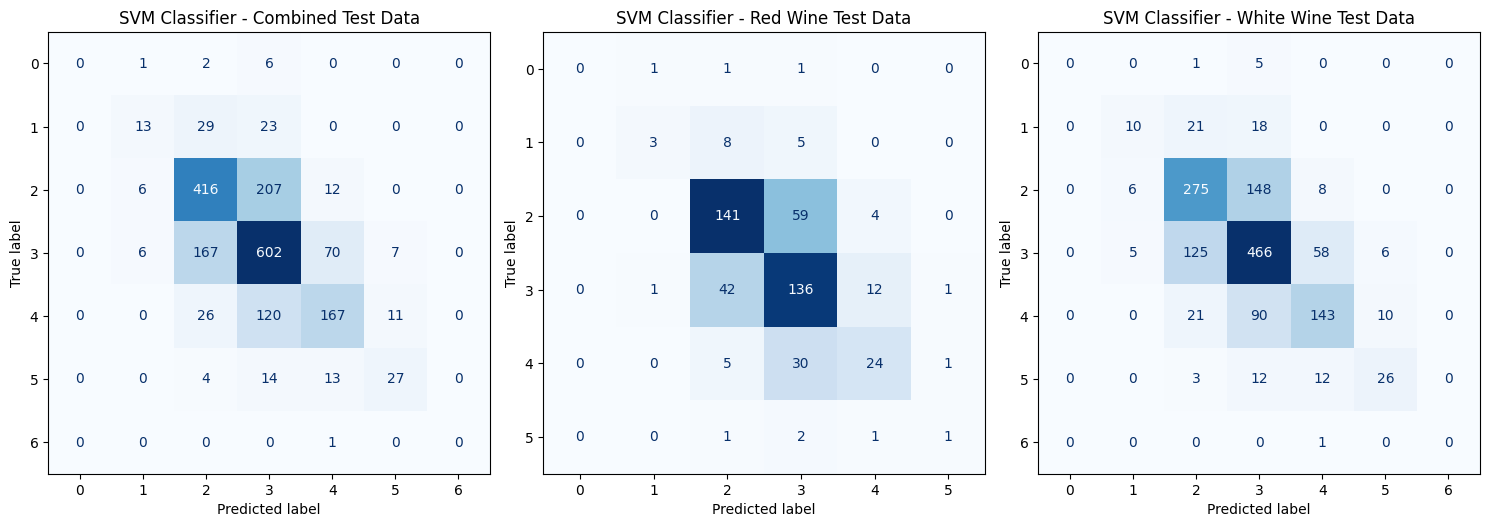

In [111]:
# Train model with best parameters
optimized_svm_classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel=best_params_svm['kernel'],
        C=best_params_svm['C'],
        gamma=best_params_svm['gamma'],
        coef0=best_params_svm.get('coef0', 0.0),
        degree=best_params_svm.get('degree', 3),
        random_state=42
    ))
])

# Fit the optimized model
optimized_svm_classifier.fit(X_train, y_train)
# Evaluate
optimized_svm_classifier_results = evaluate_model(
    optimized_svm_classifier,
    X_test, y_test, red_test={"x": X_test_red, "y": y_test_red}, white_test={
        "x": X_test_white, "y": y_test_white
    }
)
print_evaluation_results(optimized_svm_classifier_results, title="SVM Classifier")
plot_confusion_matrix({
    'y_pred': [optimized_svm_classifier.predict(X_test), optimized_svm_classifier.predict(X_test_red), optimized_svm_classifier.predict(X_test_white)],
    'y_test': [y_test, y_test_red, y_test_white],
    'model_name': ["SVM Classifier - Combined Test Data", "SVM Classifier - Red Wine Test Data", "SVM Classifier - White Wine Test Data"]
})

## 4.II. Build, Train, and Evaluate <mark style="background-color: #fff000;"> MLP classifier </mark>


<mark style="background-color: #fff000;">Item 1. Train SVM, MLP, Random Forest, and Gradient Boosting classifiers on the data. 
You are free to do your own hyper-parameter tuning.</mark>

In [112]:
# Sourcecode adapted from AI221 repo: 
import numpy as np
from time import time
import matplotlib.pyplot as plt
from scipy.stats import randint, loguniform
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

model_params = {'alpha': loguniform(1e-4, 10),
                'solver': ['sgd','adam'],
                'hidden_layer_sizes': randint(4,16),
                'activation': ['identity','logistic','tanh','relu']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

n_iter = 50
optimized_mlp_classifier = RandomizedSearchCV(MLPClassifier(max_iter=5000), cv=cv,
                                   param_distributions=model_params, 
                                   n_iter=n_iter, verbose=1)

start = time()
optimized_mlp_classifier.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

# Print best parameters after tuning
print(optimized_mlp_classifier.best_params_)
  
# Print how our model looks after hyper-parameter tuning
print(optimized_mlp_classifier.best_estimator_)


Fitting 15 folds for each of 50 candidates, totalling 750 fits


c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV took 515.52 seconds for 50 candidates parameter settings.
{'activation': 'logistic', 'alpha': np.float64(0.0042258746449961694), 'hidden_layer_sizes': 6, 'solver': 'adam'}
MLPClassifier(activation='logistic', alpha=np.float64(0.0042258746449961694),
              hidden_layer_sizes=6, max_iter=5000)



MLP Classifier
Model results on Test Data (Overall, Red Wine, White Wine).

   Dataset  Accuracy  F1-Score  Precision   Recall
   Overall  0.537949  0.481074   0.506352 0.537949
  Red Wine  0.560417  0.505802   0.461339 0.560417
White Wine  0.530612  0.470492   0.500033 0.530612


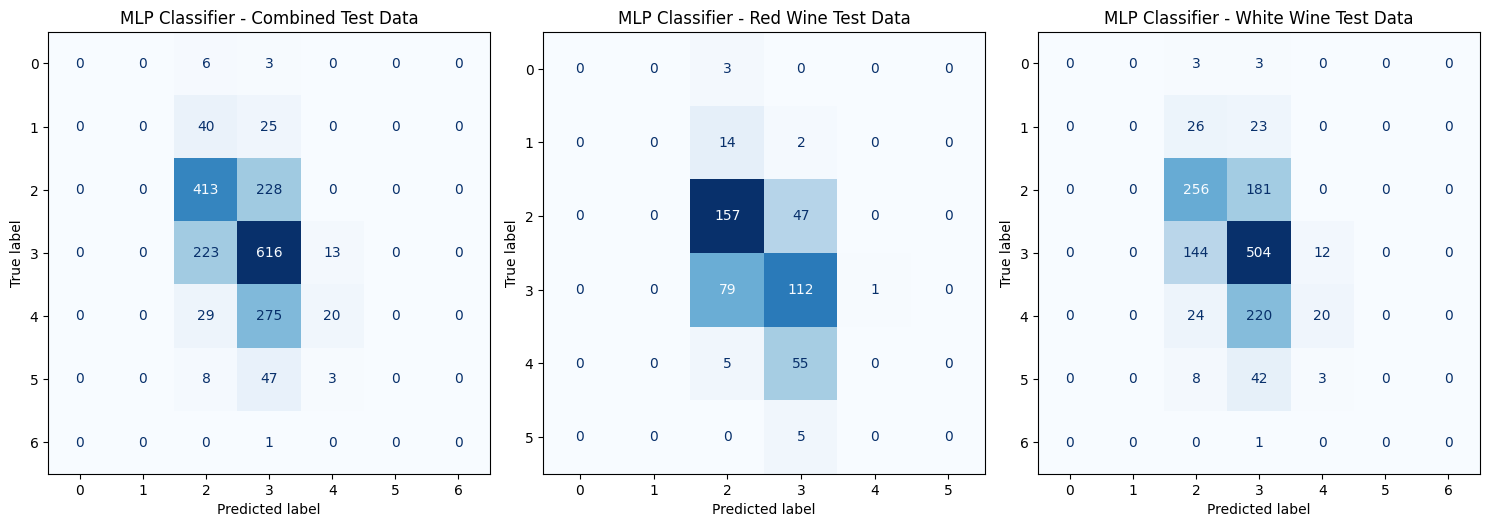

In [113]:

y = optimized_mlp_classifier.predict(X_test)

optimized_mlp_classifier_results = evaluate_model(
    optimized_mlp_classifier,
    X_test, y_test, red_test={"x": X_test_red, "y": y_test_red}, white_test={
        "x": X_test_white, "y": y_test_white
    }
)

print_evaluation_results(optimized_mlp_classifier_results, title="MLP Classifier")
plot_confusion_matrix({
    'y_pred': [optimized_mlp_classifier.predict(X_test), optimized_mlp_classifier.predict(X_test_red), optimized_mlp_classifier.predict(X_test_white)],
    'y_test': [y_test, y_test_red, y_test_white],
    'model_name': ["MLP Classifier - Combined Test Data", "MLP Classifier - Red Wine Test Data", "MLP Classifier - White Wine Test Data"]
})

## 4.III. Build, Train, and Evaluate <mark style="background-color: #fff000;"> Random Forest classifier </mark>


<mark style="background-color: #fff000;">Item a. Train SVM, MLP, Random Forest, and Gradient Boosting classifiers on the data. 
You are free to do your own hyper-parameter tuning.</mark>

In [114]:

from sklearn.ensemble import RandomForestClassifier


def objective_rf_classifier(trial):
    """Optuna objective function for RBF kernel SVM"""
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 5, 50, step=5)
    
    
    # Create pipeline
    pipeline =  Pipeline([
               ("classifier", RandomForestClassifier(n_estimators=n_estimators,max_depth=20,random_state=42))])
    
    # Train and evaluate
    pipeline.fit(X_train, y_train)
    y_val_pred = pipeline.predict(X_test)
    
    # Return F1-macro score (maximize)
    return f1_score(y_test, y_val_pred, average='macro')


study_rf_classifier = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)
study_rf_classifier.optimize(objective_rf_classifier, n_trials=50, show_progress_bar=True)

# Get best parameters
best_params_rf_classifier = study_rf_classifier.best_params
print(f"\nBest parameters for Random Forest Classifier:")
print(f"  n_estimators: {best_params_rf_classifier['n_estimators']}")
print(f"  max_depth: {best_params_rf_classifier['max_depth']}")




  0%|          | 0/50 [00:00<?, ?it/s]


Best parameters for Random Forest Classifier:
  n_estimators: 600
  max_depth: 20



Random Forest Classifier
Model results on Test Data (Overall, Red Wine, White Wine).

   Dataset  Accuracy  F1-Score  Precision   Recall
   Overall  0.672821  0.658205   0.673701 0.672821
  Red Wine  0.664583  0.642884   0.636727 0.664583
White Wine  0.675510  0.662081   0.680997 0.675510


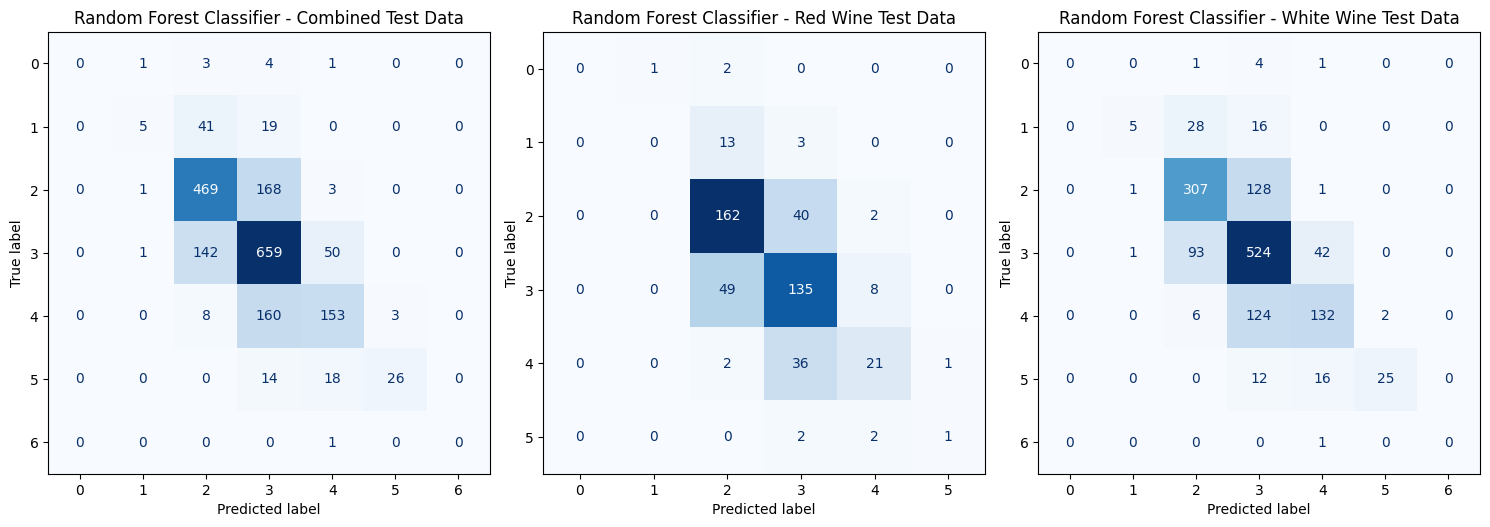

In [115]:
optimized_random_forest_classifier = Pipeline([
               ("classifier", RandomForestClassifier(n_estimators=best_params_rf_classifier["n_estimators"],max_depth=best_params_rf_classifier["max_depth"],random_state=42))])

optimized_random_forest_classifier.fit(X_train, y_train)

optimized_random_forest_classifier_results = evaluate_model(optimized_random_forest_classifier, X_test, y_test, red_test={
    "x": X_test_red, "y": y_test_red
}, white_test={
    "x": X_test_white, "y": y_test_white
})

print_evaluation_results(optimized_random_forest_classifier_results, "Random Forest Classifier")

plot_confusion_matrix({
    'y_pred': [optimized_random_forest_classifier.predict(X_test), optimized_random_forest_classifier.predict(X_test_red), optimized_random_forest_classifier.predict(X_test_white)],
    'y_test': [y_test, y_test_red, y_test_white],
    'model_name': ["Random Forest Classifier - Combined Test Data", "Random Forest Classifier - Red Wine Test Data", "Random Forest Classifier - White Wine Test Data"]
})

## 4.IV. Build, Train, and Evaluate <mark style="background-color: #fff000;"> Gradient Boosting classifier </mark>


<mark style="background-color: #fff000;">Item 1. Train SVM, MLP, Random Forest, and Gradient Boosting classifiers on the data. 
You are free to do your own hyper-parameter tuning.</mark>

In [116]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

dtrain_clf = xgb.DMatrix(X_train, label=y_train_encoded, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, label=y_test_encoded, enable_categorical=True)

params = {
    "objective": "multi:softprob",
    "num_class": len(label_encoder.classes_),
    "eval_metric": "mlogloss"
}

import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import f1_score
import xgboost as xgb
import numpy as np

def objective_xgb_classifier(trial):
    # Suggest hyperparameters
    param = {
        "objective": "multi:softprob",
        "num_class": len(label_encoder.classes_),
        "eval_metric": "mlogloss",
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "verbosity": 0,
    }

    # Convert to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
    dtest = xgb.DMatrix(X_test, label=y_test_encoded)

    # Train model
    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=trial.suggest_int("num_boost_round", 100, 1000),
        evals=[(dtest, "test")],
        verbose_eval=False,
    )

    # Predict and evaluate
    y_pred = model.predict(dtest)
    y_pred_classes = np.argmax(y_pred, axis=1)
    score = f1_score(y_test_encoded, y_pred_classes, average="weighted")

    # We want to maximize F1-score
    return score


# Create and run Optuna study
study_xgb_classifier = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
study_xgb_classifier.optimize(objective_xgb_classifier, n_trials=50, show_progress_bar=True)

# Show best parameters
best_params_xgb = study_xgb_classifier.best_params
print("\nBest parameters for XGBoost Classifier:")
for k, v in best_params_xgb.items():
    print(f"  {k}: {v}")


  0%|          | 0/50 [00:00<?, ?it/s]


Best parameters for XGBoost Classifier:
  max_depth: 12
  learning_rate: 0.1281741148836629
  subsample: 0.8763482616591941
  colsample_bytree: 0.7310004024119443
  gamma: 0.4307992696010211
  min_child_weight: 2
  lambda: 0.006009839841712242
  alpha: 0.06361226904953433
  num_boost_round: 362



XGBoost Classifier
Model results on Test Data (Overall, Red Wine, White Wine).

   Dataset  Accuracy  F1-Score  Precision   Recall
   Overall  0.671282  0.658494   0.668181 0.671282
  Red Wine  0.668750  0.648215   0.650763 0.668750
White Wine  0.672109  0.660595   0.671597 0.672109


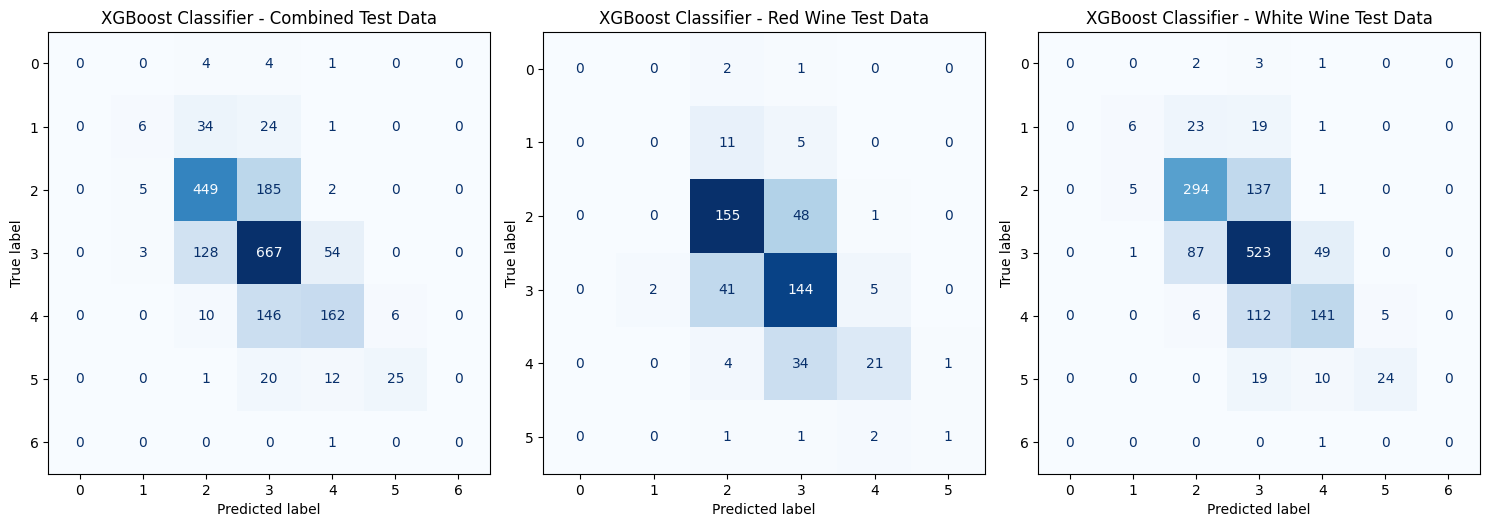

In [117]:
best_params_xgb.update({
    "objective": "multi:softprob",
    "num_class": len(label_encoder.classes_),
    "eval_metric": "mlogloss"
})

optimized_xgb_classifier = xgb.train(
    params=best_params_xgb,
    dtrain=dtrain_clf,
    num_boost_round=best_params_xgb["num_boost_round"],
    evals=[(dtrain_clf, "train"), (dtest_clf, "test")],
    verbose_eval=False,
)


optimized_xgb_classifier_results = evaluate_model(optimized_xgb_classifier, X_test, y_test, red_test={"x": X_test_red, "y": y_test_red}, white_test={"x": X_test_white, "y": y_test_white})

print_evaluation_results(optimized_xgb_classifier_results, "XGBoost Classifier")

# Note, the lowest rating is 3, so we add 3; such way 0 becomes 3, and 7 become 10
plot_confusion_matrix({
    'y_pred': [np.argmax(optimized_xgb_classifier.predict(xgb.DMatrix(X_test)), axis=1) + 3,np.argmax(optimized_xgb_classifier.predict(xgb.DMatrix(X_test_red)), axis=1) + 3, np.argmax(optimized_xgb_classifier.predict(xgb.DMatrix(X_test_white)), axis=1) + 3],
    'y_test': [y_test, y_test_red, y_test_white],
    'model_name': ["XGBoost Classifier - Combined Test Data", "XGBoost Classifier - Red Wine Test Data", "XGBoost Classifier - White Wine Test Data"]
})


# 5. Train SVR, MLP, Random Forest, and Gradient Boosting regressors


<mark style="background-color: #fff000;">Item b. Use SVR, MLP, Random Forest, and Gradient Boosting regressors</mark>

## 5.0. Utility functions


<mark style="background-color: #fff000;">Item b. <mark style="background-color: #fff000;">Item b. Report the MSE, R2, and MAD (mean absolute) on test data.</mark>

In [118]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------------
# Evaluate a regression model (returns MSE, R2, MAE)
# --------------------------------------------------------
def evaluate_regression_model(model, X_test, y_test, red_test=None, white_test=None):
   
    try:
        # Case 1: xgboost.train model (booster)
        if isinstance(model, xgb.Booster):
            dtest = xgb.DMatrix(X_test)
            y_pred = model.predict(dtest)
        else:
            # Case 2: sklearn-compatible models (pipeline, MLP, SVR, RF, XGBRegressor)
            y_pred = model.predict(X_test) 
    except Exception as e:
        raise RuntimeError(f"Prediction failed: {e}")

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mad = np.mean(np.abs(y_test - np.mean(y_test)))  
    results = {
        "mse": mse,
        "r2": r2,
        "mae": mae,
        "mad": mad,
    }

    # Optional: evaluate on red and white test sets if provided
    if red_test is not None:
        x_red_test = red_test['x']
        y_red_test = red_test['y']
        evaluate_red = evaluate_regression_model(model, x_red_test, y_red_test)
        results['red_wine'] = evaluate_red

    if white_test is not None:
        x_white_test = white_test['x']
        y_white_test = white_test['y']
        evaluate_white = evaluate_regression_model(model, x_white_test, y_white_test)
        results['white_wine'] = evaluate_white

    return results


# --------------------------------------------------------
# Plot regression residual plots for multiple models
# --------------------------------------------------------
def plot_regression_residuals(data):
    """
    data: dict with keys ['y_pred', 'y_test', 'model_name'], each containing lists for multiple models
    Example:
        data = {
            'y_pred': [y_pred_lr, y_pred_rf],
            'y_test': [y_test, y_test],
            'model_name': ['Linear Regression', 'Random Forest']
        }
    """
    n_models = len(data['model_name'])
    fig, axes = plt.subplots(1, n_models, figsize=(n_models * 6, 5))

    if n_models == 1:
        axes = [axes]

    for i, (y_pred, y_test, model_name) in enumerate(
        zip(data['y_pred'], data['y_test'], data['model_name'])
    ):
        residuals = y_test - y_pred
        sns.scatterplot(x=y_pred, y=residuals, ax=axes[i])
        axes[i].axhline(0, color='red', linestyle='--')
        axes[i].set_title(f"Residual Plot - {model_name}")
        axes[i].set_xlabel("Predicted Values")
        axes[i].set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()


def plot_actual_vs_predicted(data):
    """
    Plots Actual vs Predicted scatter plots for multiple regression models.

    Parameters
    ----------
    data : dict
        Must contain:
            - 'y_pred': list of model predictions
            - 'y_test': list of corresponding true values
            - 'model_name': list of model names (same length as above)
        Example:
            data = {
                'y_pred': [y_pred_lr, y_pred_rf],
                'y_test': [y_test, y_test],
                'model_name': ['Linear Regression', 'Random Forest']
            }
    """
    n_models = len(data['model_name'])
    fig, axes = plt.subplots(1, n_models, figsize=(n_models * 6, 5))

    if n_models == 1:
        axes = [axes]

    for i, (y_pred, y_test, model_name) in enumerate(
        zip(data['y_pred'], data['y_test'], data['model_name'])
    ):
        sns.scatterplot(x=y_test, y=y_pred, ax=axes[i])
        # Plot ideal line y = x
        min_val = min(min(y_test), min(y_pred))
        max_val = max(max(y_test), max(y_pred))
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        axes[i].set_title(f"Actual vs Predicted - {model_name}")
        axes[i].set_xlabel("Actual Values")
        axes[i].set_ylabel("Predicted Values")
        axes[i].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()
    
# --------------------------------------------------------
# Store model results in a dictionary
# --------------------------------------------------------
def store_regression_results(model_name, evaluation_metrics, results_dict):
    results_dict[model_name] = evaluation_metrics


# --------------------------------------------------------
# Print evaluation results
# --------------------------------------------------------
def print_regression_results(evaluation, title):
    print(f"\n{title}")
    print("Model results on Test Data (Overall, Red Wine, White Wine).\n")
    
    # Combine overall, red wine, and white wine results into a single table
    results = pd.DataFrame({
        "Dataset": ["Overall", "Red Wine", "White Wine"],
        "MSE": [
            evaluation.get("mse"),
            evaluation.get("red_wine", {}).get("mse"),
            evaluation.get("white_wine", {}).get("mse")
        ],
        "R²": [
            evaluation.get("r2"),
            evaluation.get("red_wine", {}).get("r2"),
            evaluation.get("white_wine", {}).get("r2")
        ],
        "MAE": [
            evaluation.get("mad"),
            evaluation.get("red_wine", {}).get("mad"),
            evaluation.get("white_wine", {}).get("mad")
        ],
    })
    
    print("=" * 50)
    # Print the combined table
    print(results.to_string(index=False))
    print("=" * 50)

## 5.I. Build, Train, and Evaluate <mark style="background-color: #fff000;"> SVM Regressor </mark>


<mark style="background-color: #fff000;">Item b. use SVR, MLP, Random Forest, and Gradient Boosting regressors.</mark>

In [119]:
import optuna
from optuna.samplers import TPESampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

def objective_svr(trial):
    """Optuna objective function for SVR (Support Vector Regression)"""

    # Suggest hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    C = trial.suggest_float('C', 0.1, 100.0, log=True)
    gamma = trial.suggest_float('gamma', 0.001, 1.0, log=True)
    epsilon = trial.suggest_float('epsilon', 0.001, 1.0, log=True)

    # Create pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR(kernel=kernel, C=C, gamma=gamma, epsilon=epsilon))
    ])

    # Train and predict
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mad = mean_absolute_error(y_test, y_pred)

    # Log metrics to Optuna
    trial.set_user_attr("mse", mse)
    trial.set_user_attr("r2", r2)
    trial.set_user_attr("mad", mad)

    # We want to maximize R² (goodness of fit)
    return r2


# --- Run Optuna Study ---
print("Optimizing SVR with Optuna...")
study_svr = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)
study_svr.optimize(objective_svr, n_trials=50, show_progress_bar=True)

# --- Get Best Parameters ---
best_params_svr = study_svr.best_params
print("\nBest parameters for SVR:")
print(f"  Kernel: {best_params_svr['kernel']}")
print(f"  C: {best_params_svr['C']:.4f}")
print(f"  Gamma: {best_params_svr['gamma']:.4f}")
print(f"  Epsilon: {best_params_svr['epsilon']:.4f}")




Optimizing SVR with Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]


Best parameters for SVR:
  Kernel: rbf
  C: 1.0604
  Gamma: 0.5029
  Epsilon: 0.0222



SVM Regressor
Model results on Test Data (Overall, Red Wine, White Wine).

   Dataset      MSE       R²      MAE
   Overall 0.432057 0.431646 0.684957
  Red Wine 0.399971 0.383074 0.682075
White Wine 0.442535 0.434305 0.670415


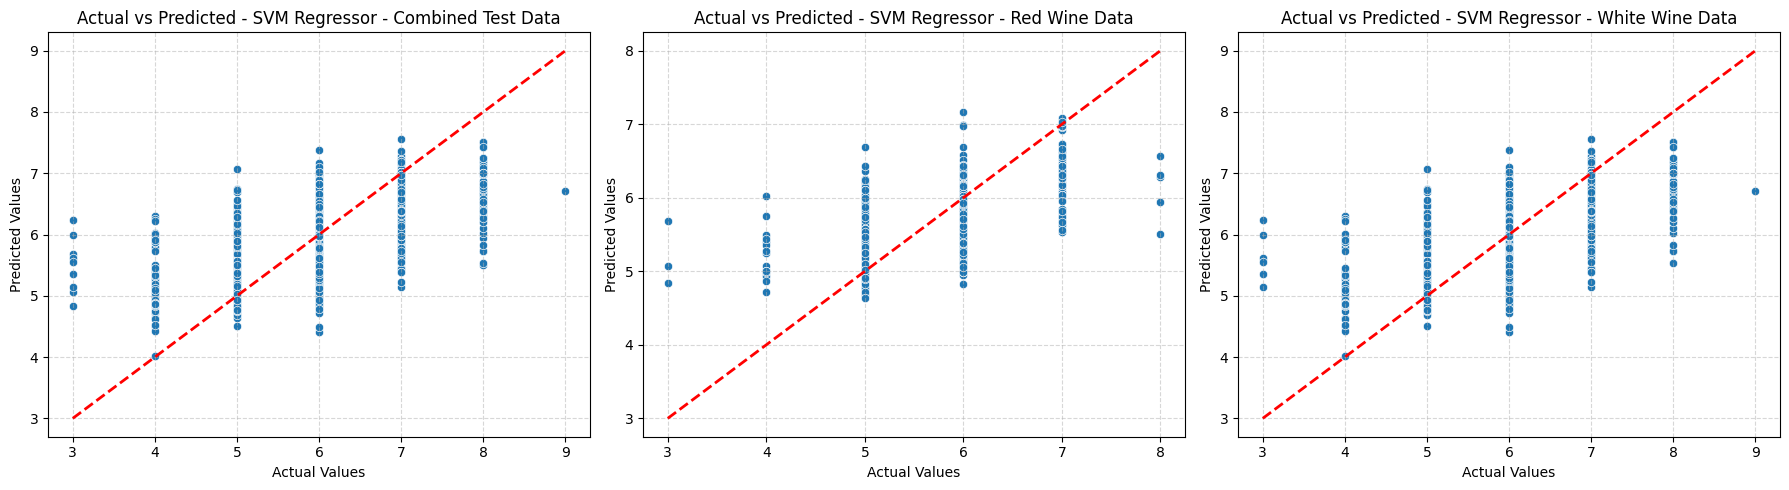

In [120]:
# --- Evaluate the final best model ---
optimized_svm_regressor = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(**best_params_svr))
])

optimized_svm_regressor.fit(X_train, y_train)

optimized_svm_regressor_results = evaluate_regression_model(optimized_svm_regressor, X_test, y_test, 
                                                           red_test={"x":X_test_red, "y": y_test_red}, white_test={"x": X_test_white, "y": y_test_white})

print_regression_results(optimized_svm_regressor_results, "SVM Regressor")
plot_actual_vs_predicted({
    "y_pred" : [optimized_svm_regressor.predict(X_test),optimized_svm_regressor.predict(X_test_red),optimized_svm_regressor.predict(X_test_white)],
    "y_test": [y_test, y_test_red, y_test_white],
    "model_name": ["SVM Regressor - Combined Test Data", "SVM Regressor - Red Wine Data", "SVM Regressor - White Wine Data"]
})


## 5.II. Build, Train, and Evaluate <mark style="background-color: #fff000;"> MLP Regressor </mark>


<mark style="background-color: #fff000;">Item b. use SVR, MLP, Random Forest, and Gradient Boosting regressors.</mark>

In [138]:
from time import time
from scipy.stats import randint, loguniform
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# --- Create pipeline with imputation and scaling ---
mlp_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),      # Handles missing values
    ("scaler", StandardScaler()),                     # Normalizes features
    ("mlp", MLPRegressor(max_iter=5000, random_state=42))
])

# --- Define hyperparameter search space ---
model_params = {
    "mlp__alpha": loguniform(1e-4, 10),
    "mlp__solver": ['adam', 'sgd'],
    "mlp__hidden_layer_sizes": randint(4, 16),
    "mlp__activation": ['identity', 'logistic', 'tanh', 'relu'],
    "mlp__learning_rate_init": loguniform(1e-5, 1e-2)  # add stable learning rate search
}

# --- Repeated K-Fold for regression ---
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# --- RandomizedSearchCV for MLPRegressor ---
n_iter = 50
optimized_mlp_regressor = RandomizedSearchCV(
    mlp_pipeline,
    param_distributions=model_params,
    n_iter=n_iter,
    cv=cv,
    verbose=1,
    n_jobs=1,
    scoring='r2'  # R² is standard for regression
)

# --- Train the model ---
start = time()
optimized_mlp_regressor.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
      % ((time() - start), n_iter))

# --- Best parameters ---
print("\nBest Parameters:")
print(optimized_mlp_regressor.best_params_)

# --- Optional: Evaluate on test set ---
y_pred = optimized_mlp_regressor.predict(X_test)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("\nEvaluation Metrics on Test Set:")
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")


Fitting 15 folds for each of 50 candidates, totalling 750 fits


c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the opti

RandomizedSearchCV took 1169.35 seconds for 50 candidates parameter settings.

Best Parameters:
{'mlp__activation': 'tanh', 'mlp__alpha': np.float64(0.0011752320967277974), 'mlp__hidden_layer_sizes': 12, 'mlp__learning_rate_init': np.float64(0.005419373090462106), 'mlp__solver': 'sgd'}

Evaluation Metrics on Test Set:
R²: 0.3435
MAE: 0.5483
MSE: 0.4991



MLP Reggressor
Model results on Test Data (Overall, Red Wine, White Wine).

   Dataset      MSE       R²      MAE
   Overall 0.499098 0.343456 0.684957
  Red Wine 0.414419 0.360789 0.682075
White Wine 0.526749 0.326654 0.670415


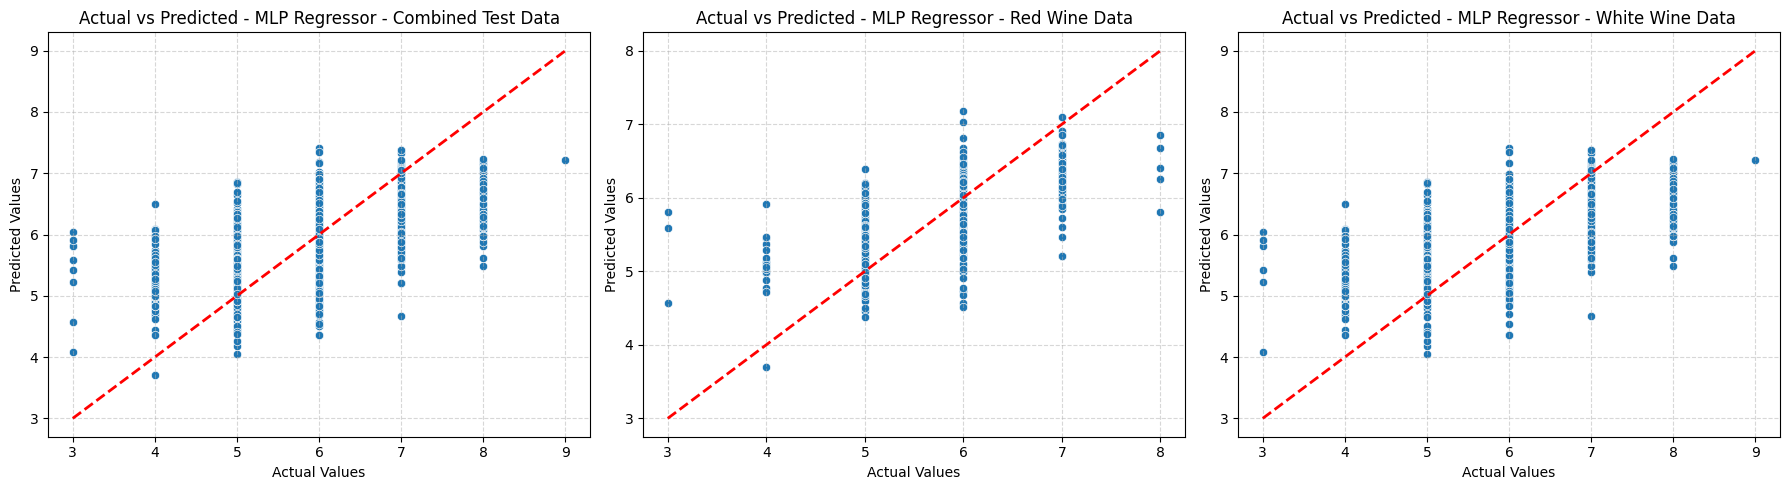

In [145]:

optimized_mlp_regressor_results = evaluate_regression_model(optimized_mlp_regressor, X_test, y_test, 
                                                            red_test={
                                                                "x":X_test_red,
                                                                "y": y_test_red,
                                                            },
                                                            white_test={
                                                                "x": X_test_white, 
                                                                "y": y_test_white
                                                            })

print_regression_results(optimized_mlp_regressor_results, "MLP Reggressor")

plot_actual_vs_predicted({
    "y_pred" : [optimized_mlp_regressor.predict(X_test),optimized_mlp_regressor.predict(X_test_red),optimized_mlp_regressor.predict(X_test_white)],
    "y_test": [y_test, y_test_red, y_test_white],
    "model_name": ["MLP Regressor - Combined Test Data", "MLP Regressor - Red Wine Data", "MLP Regressor - White Wine Data"]
})

## 5.III. Build, Train, and Evaluate <mark style="background-color: #fff000;"> Random Forest Regressor </mark>


<mark style="background-color: #fff000;">Item b. use SVR, MLP, Random Forest, and Gradient Boosting regressors.</mark>

In [123]:

from sklearn.ensemble import RandomForestRegressor

def objective_rf_regressor(trial):
    """Optuna objective function for Random Forest Regressor"""
    
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 5, 50, step=5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    
    # Create pipeline
    pipeline = Pipeline([
        ("regressor", RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    # Train and predict
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Compute regression metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Log metrics
    trial.set_user_attr("mse", mse)
    trial.set_user_attr("mae", mae)
    trial.set_user_attr("r2", r2)
    
    # We want to maximize R²
    return r2


# --- Run Optuna Study ---
print("Optimizing Random Forest Regressor with Optuna...")
study_rf_regressor = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)
study_rf_regressor.optimize(objective_rf_regressor, n_trials=50, show_progress_bar=True)

# --- Get Best Parameters ---
best_params_rf_regressor = study_rf_regressor.best_params
print("\nBest Parameters for Random Forest Regressor:")
for k, v in best_params_rf_regressor.items():
    print(f"  {k}: {v}")

Optimizing Random Forest Regressor with Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]


Best Parameters for Random Forest Regressor:
  n_estimators: 600
  max_depth: 35
  min_samples_split: 2
  min_samples_leaf: 1



Random Forest Regressor
Model results on Test Data (Overall, Red Wine, White Wine).

   Dataset      MSE       R²      MAE
   Overall 0.364423 0.520616 0.684957
  Red Wine 0.335518 0.482488 0.682075
White Wine 0.373862 0.522090 0.670415


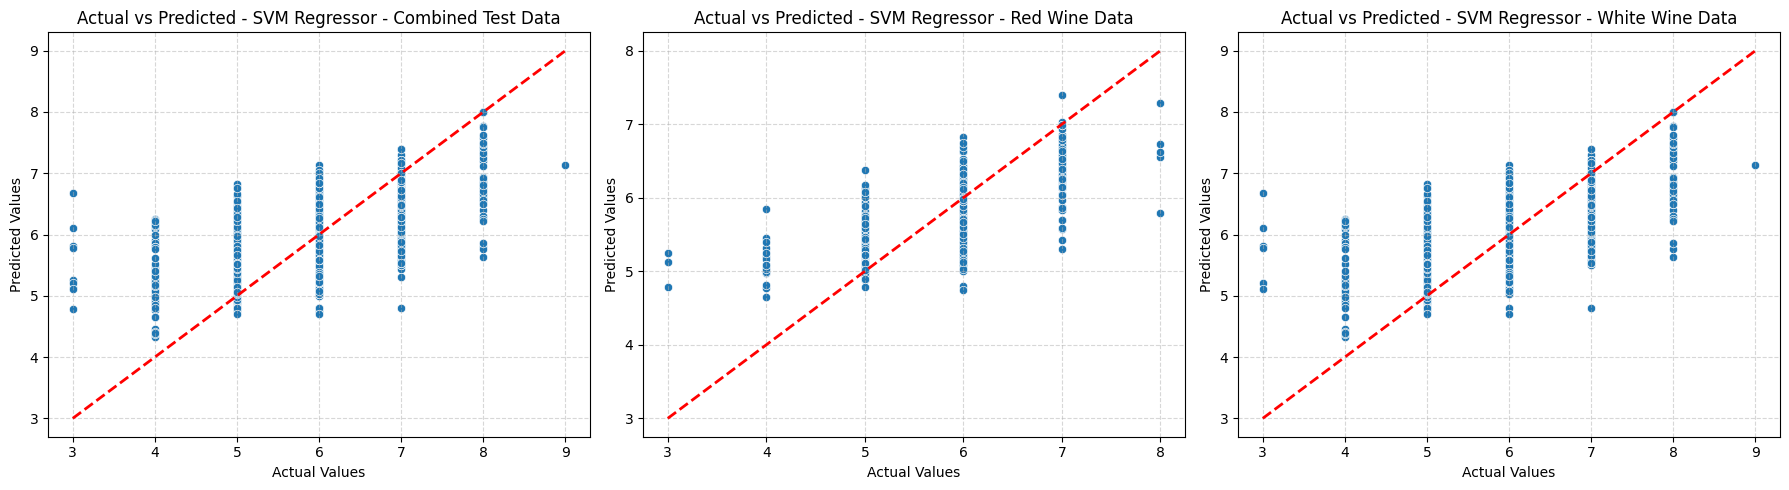

In [124]:
optimized_random_forest_regressor = RandomForestRegressor(
    **best_params_rf_regressor, random_state=42, n_jobs=-1
)
optimized_random_forest_regressor.fit(X_train, y_train)

optimized_random_forest_regressor_results = evaluate_regression_model(optimized_random_forest_regressor, X_test, y_test, 
                                                                      red_test={
                                                                          "x": X_test_red,
                                                                          "y": y_test_red
                                                                      }, 
                                                                      white_test={
                                                                          "x": X_test_white,
                                                                          "y": y_test_white
                                                                      })

print_regression_results(optimized_random_forest_regressor_results, "Random Forest Regressor")

plot_actual_vs_predicted({
    "y_pred" : [optimized_random_forest_regressor.predict(X_test),optimized_random_forest_regressor.predict(X_test_red),optimized_random_forest_regressor.predict(X_test_white)],
    "y_test": [y_test, y_test_red, y_test_white],
    "model_name": ["SVM Regressor - Combined Test Data", "SVM Regressor - Red Wine Data", "SVM Regressor - White Wine Data"]
})


## 5.IV. Build, Train, and Evaluate <mark style="background-color: #fff000;"> Gradient Boosting Regressor </mark>


<mark style="background-color: #fff000;">Item b. use SVR, MLP, Random Forest, and Gradient Boosting regressors.</mark>

In [125]:
def objective_xgb_regressor(trial):
    # Suggest hyperparameters
    param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "verbosity": 0,
    }

    # Convert to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Train model
    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=trial.suggest_int("num_boost_round", 100, 1000),
        evals=[(dtest, "test")],
        verbose_eval=False,
    )

    # Predict and evaluate
    y_pred = model.predict(dtest)

    # Use R² as optimization metric
    score = r2_score(y_test, y_pred)
    return score  # maximize R²


# Create and run Optuna study
study_xgb_regressor = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
study_xgb_regressor.optimize(objective_xgb_regressor, n_trials=50, show_progress_bar=True)

# Show best parameters
best_params_xgb = study_xgb_regressor.best_params
print("\nBest parameters for XGBoost Regressor:")
for k, v in best_params_xgb.items():
    print(f"  {k}: {v}")


  0%|          | 0/50 [00:00<?, ?it/s]


Best parameters for XGBoost Regressor:
  max_depth: 15
  learning_rate: 0.06856104254924009
  subsample: 0.9679093099039704
  colsample_bytree: 0.7838381267832939
  gamma: 0.012231462403902934
  min_child_weight: 9
  lambda: 0.0010738907556928795
  alpha: 0.0333641890878912
  num_boost_round: 143



XGBoost Regressor
Model results on Test Data (Overall, Red Wine, White Wine).

   Dataset      MSE       R²      MAE
   Overall 0.364421 0.520619 0.684957
  Red Wine 0.333003 0.486367 0.682075
White Wine 0.374680 0.521044 0.670415


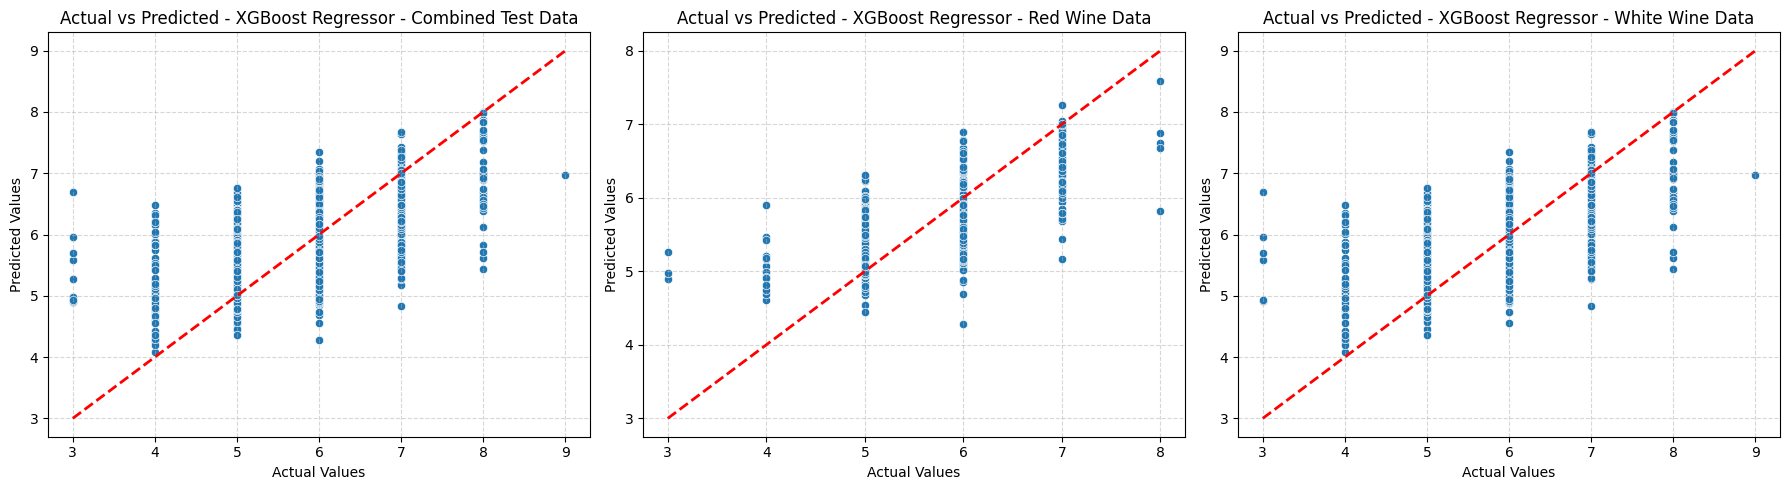

In [126]:
optimized_xgb_regressor = xgb.train(
    params={**best_params_xgb, "objective": "reg:squarederror", "eval_metric": "rmse"},
    dtrain=xgb.DMatrix(X_train, label=y_train),
    num_boost_round=best_params_xgb.get("num_boost_round", 200)
)



optimized_xgb_regressor_results = evaluate_regression_model(optimized_xgb_regressor, X_test, y_test, 
                                                                      red_test={
                                                                          "x": X_test_red,
                                                                          "y": y_test_red
                                                                      }, 
                                                                      white_test={
                                                                          "x": X_test_white,
                                                                          "y": y_test_white
                                                                      })

print_regression_results(optimized_xgb_regressor_results, "XGBoost Regressor")

plot_actual_vs_predicted({
    "y_pred" : [optimized_xgb_regressor.predict(xgb.DMatrix(X_test)),optimized_xgb_regressor.predict(xgb.DMatrix(X_test_red)),optimized_xgb_regressor.predict(xgb.DMatrix(X_test_white))],
    "y_test": [y_test, y_test_red, y_test_white],
    "model_name": ["XGBoost Regressor - Combined Test Data", "XGBoost Regressor - Red Wine Data", "XGBoost Regressor - White Wine Data"]
})


# 6. Results And Comparison


<mark style="background-color: #fff000;">Item b. Were you able to improve against the result in the paper? </mark>

The overall accuracies reported in the paper are <mark style="background-color: #fff000;">62.4% (red) and 64.6% (white). </mark>

For classification models, <mark style="background-color: #fff000;"> Random Forest</mark> and <mark style="background-color: #fff000;"> XGBoost </mark> classifiers has outperformed the paper's accuracy, with overall accuracies <mark style="background-color: #fff000;"> 67.28% (66.45% for red wine,67.55% for white wine)</mark> and <mark style="background-color: #fff000;"> 67.12% (67.21% for red wine, 66.88% for white wine), respectively.</mark>


Original Paper: 
https://www.sciencedirect.com/science/article/pii/S0167923609001377



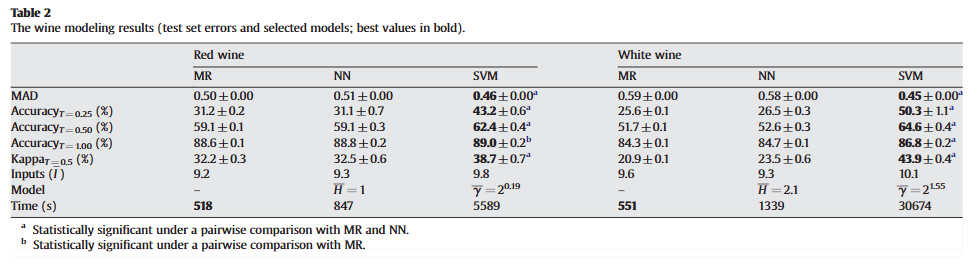

In [127]:
result_table_path = "./data/wine_manu_table2.png"

from IPython.display import Image, display

# Display the images
display(Image(filename=result_table_path))

## 6.I. Classification 

In [ ]:
classifier_models = [optimized_svm_classifier, optimized_mlp_classifier, optimized_random_forest_classifier, optimized_xgb_classifier]
classifier_results = [optimized_svm_classifier_results, optimized_mlp_classifier_results, optimized_random_forest_classifier_results, optimized_xgb_classifier_results]

classifier_model_names = [
     "svm_classifier",
    "mlp_classifier",
    "random_forest_classifier",
    "xgb_classifier"
]

# prompt: find best models for each metric: accuracy, recall, precision, f1-score


def find_best_models_by_metric(models, results, model_names):
    """
    Finds the best model for each classification metric: accuracy, precision, recall, and F1-score.
    
    Parameters
    ----------
    models : list
        List of model objects or their names.
    results : list of dict
        List of result dictionaries (from evaluate_model()) corresponding to each model.
    
    Returns
    -------
    pd.DataFrame
        DataFrame summarizing all results and showing the best model per metric.
    """
    # Build a DataFrame for easy comparison
    metrics_data = []
    for model, res, model_name in zip(models, results, model_names):
        # Allow both model objects and string names
       
        metrics_data.append({
            "Model": model_name,
            "Accuracy": res.get("accuracy", None),
            "Precision": res.get("precision", None),
            "Recall": res.get("recall", None),
            "F1-Score": res.get("f1", None), 
            "[R] Accuracy": res.get("red_wine", {}).get("accuracy"),
            "[R] Precision": res.get("red_wine", {}).get("precision"),
            "[R] Recall": res.get("red_wine", {}).get("recall"),
            "[R] F1-Score": res.get("red_wine", {}).get("f1"),
            "[W] Accuracy": res.get("white_wine", {}).get("accuracy"),
            "[W] Precision": res.get("white_wine", {}).get("precision"),
            "[W] Recall": res.get("white_wine", {}).get("recall"),
            "[W] F1-Score": res.get("white_wine", {}).get("f1")
        })
    
    df = pd.DataFrame(metrics_data)

    # Find best model per metric
    best_models = {
        "Accuracy": df.loc[df["Accuracy"].idxmax(), "Model"],
        "Precision": df.loc[df["Precision"].idxmax(), "Model"],
        "Recall": df.loc[df["Recall"].idxmax(), "Model"],
        "F1-Score": df.loc[df["F1-Score"].idxmax(), "Model"],
       
    }

    print("\n🏆 Best Models by Metric:")
    for metric, model_name in best_models.items():
        print(f"  {metric}: {model_name}")

    return df, best_models



df_results, best_models = find_best_models_by_metric(classifier_models, classifier_results, classifier_model_names)

print("\nClassification Model Results: \n [R] - Red Wine\n [W] - White Wine")
display(df_results)


🏆 Best Models by Metric:
  Accuracy: random_forest_classifier
  Precision: random_forest_classifier
  Recall: random_forest_classifier
  F1-Score: xgb_classifier

All Model Results: 
 [R] - Red Wine
 [W] - White Wine


,Model,Accuracy,Precision,Recall,F1-Score,[R] Accuracy,[R] Precision,[R] Recall,[R] F1-Score,[W] Accuracy,[W] Precision,[W] Recall,[W] F1-Score
0,svm_classifier,0.628205,0.622962,0.628205,0.620901,0.635417,0.632771,0.635417,0.625668,0.625850,0.620294,0.625850,0.619218
1,mlp_classifier,0.537949,0.506352,0.537949,0.481074,0.560417,0.461339,0.560417,0.505802,0.530612,0.500033,0.530612,0.470492
2,random_forest_classifier,0.672821,0.673701,0.672821,0.658205,0.664583,0.636727,0.664583,0.642884,0.675510,0.680997,0.675510,0.662081
3,xgb_classifier,0.671282,0.668181,0.671282,0.658494,0.668750,0.650763,0.668750,0.648215,0.672109,0.671597,0.672109,0.660595


## 6.II. Regression


In [146]:
def evaluate_regression_accuracy(y_pred, y_test, tolerance = 0.5):
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    
    # Calculate absolute difference
    diff = np.abs(y_pred - y_test)
    
    # Count how many predictions are within the tolerance
    within_tolerance = np.sum(diff <= tolerance)
    
    # Compute accuracy as a percentage
    accuracy = within_tolerance / len(y_test)
    
    return accuracy

In [148]:
regressor_models = [optimized_svm_regressor, optimized_mlp_regressor, optimized_random_forest_regressor, optimized_xgb_regressor]
regressor_results = [optimized_svm_regressor_results, optimized_mlp_regressor_results, optimized_random_forest_regressor_results, optimized_xgb_regressor_results]
regressor_model_names = [
    "svm_regressor",
    "mlp_regressor",
    "random_forest_regressor",
    "xgb_regressor"
]

# prompt: find best models for each metric: mse, r2, mad

def find_best_regressors_by_metric(models, results, model_names):
    """
    Finds the best regression model for each metric: MSE, R², MAE, and MAD.

    Parameters
    ----------
    models : list
        List of regression model objects or their names.
    results : list of dict
        List of result dictionaries (from evaluate_regression_model()) corresponding to each model.
    model_names : list
        List of names corresponding to the models.

    Returns
    -------
    pd.DataFrame
        DataFrame summarizing all regression results and showing the best model per metric.
    """
    # Collect metrics for each model
    metrics_data = []
    for model, res, model_name in zip(models, results, model_names):
        metrics_data.append({
            "Model": model_name,
            "MSE": res.get("mse", None),
            "R2": res.get("r2", None),
            "MAD": res.get("mad", None),
            "[R] MSE": res.get("red_wine", {}).get("mse"),
            "[R] R2": res.get("red_wine", {}).get("r2"),
            "[R] MAD": res.get("red_wine", {}).get("mad"),
            "[W] MSE": res.get("white_wine", {}).get("mse"),
            "[W] R2": res.get("white_wine", {}).get("r2"),
            "[W] MAD": res.get("white_wine", {}).get("mad"),
        })

    # Convert to DataFrame for easy comparison
    df = pd.DataFrame(metrics_data)

    # Find best models (lower = better for MSE, MAE, MAD; higher = better for R2)
    best_models = {
        "MSE": df.loc[df["MSE"].idxmin(), "Model"],
        "R2": df.loc[df["R2"].idxmax(), "Model"],
        "MAD": df.loc[df["MAD"].idxmin(), "Model"],
    }

    print("\n🏆 Best Regression Models by Metric:")
    for metric, model_name in best_models.items():
        print(f"  {metric}: {model_name}")

    return df, best_models

def get_df_accuracy_with_tolerance(models, model_names, tolerance_list=[0.25, 0.50, 1]):
    data = []
    for model, model_name in zip(models,  model_names):
        local_dict = {"Model": model_name}
        # Combined Test Data
        for tolerance in tolerance_list:
            if isinstance(model, xgb.Booster):
                dtest = xgb.DMatrix(X_test)
                y_pred = model.predict(dtest)
            else:
                # Case 2: sklearn-compatible models (pipeline, MLP, SVR, RF, XGBRegressor)
                y_pred = model.predict(X_test)  

            acc = evaluate_regression_accuracy(y_pred, y_test, tolerance)
            local_dict[f"Acc(T={tolerance})"] = acc
        
        # Red Wine Data
        for tolerance in tolerance_list:
            if isinstance(model, xgb.Booster):
                dtest = xgb.DMatrix(X_test_red)
                y_pred = model.predict(dtest)
            else:
                # Case 2: sklearn-compatible models (pipeline, MLP, SVR, RF, XGBRegressor)
                y_pred = model.predict(X_test_red)  

            acc = evaluate_regression_accuracy(y_pred, y_test_red, tolerance)
            local_dict[f"[R] Acc(T={tolerance})"] = acc
         
        # White Wine Data
        for tolerance in tolerance_list:
            if isinstance(model, xgb.Booster):
                dtest = xgb.DMatrix(X_test_white)
                y_pred = model.predict(dtest)
            else:
                # Case 2: sklearn-compatible models (pipeline, MLP, SVR, RF, XGBRegressor)
                y_pred = model.predict(X_test_white)  

            acc = evaluate_regression_accuracy(y_pred, y_test_white, tolerance)
            local_dict[f"[W] Acc(T={tolerance})"] = acc
        data.append(local_dict)

    # Convert to DataFrame for easy comparison
    df = pd.DataFrame(data)
    return df

# Example usage:
df_regression_results, best_regressors = find_best_regressors_by_metric(
    regressor_models, regressor_results, regressor_model_names
)
df_accuracy = get_df_accuracy_with_tolerance(regressor_models, regressor_model_names)
print("\nRegression Models Result: \n [R] - Red Wine\n [W] - White Wine")
display(df_results)
print("="*50)
display(df_accuracy)



🏆 Best Regression Models by Metric:
  MSE: xgb_regressor
  R2: xgb_regressor
  MAD: svm_regressor

Regression Models Result: 
 [R] - Red Wine
 [W] - White Wine


,Model,Accuracy,Precision,Recall,F1-Score,[R] Accuracy,[R] Precision,[R] Recall,[R] F1-Score,[W] Accuracy,[W] Precision,[W] Recall,[W] F1-Score
0,svm_classifier,0.628205,0.622962,0.628205,0.620901,0.635417,0.632771,0.635417,0.625668,0.625850,0.620294,0.625850,0.619218
1,mlp_classifier,0.537949,0.506352,0.537949,0.481074,0.560417,0.461339,0.560417,0.505802,0.530612,0.500033,0.530612,0.470492
2,random_forest_classifier,0.672821,0.673701,0.672821,0.658205,0.664583,0.636727,0.664583,0.642884,0.675510,0.680997,0.675510,0.662081
3,xgb_classifier,0.671282,0.668181,0.671282,0.658494,0.668750,0.650763,0.668750,0.648215,0.672109,0.671597,0.672109,0.660595


,Model,Acc(T=0.25),Acc(T=0.5),Acc(T=1),[R] Acc(T=0.25),[R] Acc(T=0.5),[R] Acc(T=1),[W] Acc(T=0.25),[W] Acc(T=0.5),[W] Acc(T=1)
0,svm_regressor,0.409231,0.622051,0.874872,0.422917,0.637500,0.883333,0.404762,0.617007,0.872109
1,mlp_regressor,0.290256,0.551795,0.867179,0.304167,0.587500,0.893750,0.285714,0.540136,0.858503
2,random_forest_regressor,0.423590,0.680513,0.904615,0.420833,0.662500,0.906250,0.424490,0.686395,0.904082
3,xgb_regressor,0.460000,0.669744,0.908205,0.468750,0.647917,0.916667,0.457143,0.676871,0.905442


## 6.III. Classification VS Regression

<mark style="background-color: #fff000;">Based on your results, discuss the difference of treating this problem as classification or regression. How will this decision impact the users of your model?</mark>


Treating the wine quality prediction problem as a classification or regression task leads to different outcomes and implications for users.  

In classification, the model predicts discrete quality categories (e.g., scores 3–9), providing clear and interpretable labels that are useful for decision-making, such as labeling or quality approval. However, it treats all misclassifications equally, even if a prediction is only off by one point. 


In contrast, a regression model predicts continuous quality scores, capturing subtle variations between wines (e.g., predicting 6.8 instead of 7) and offering more nuanced insights for tasks like quality monitoring. While regression provides finer detail, it requires defining thresholds or tolerances to interpret results meaningfully. This is the case of the original paper (ref:https://www.sciencedirect.com/science/article/pii/S0167923609001377 )

Ultimately, classification is more practical for categorical grading, whereas regression offers deeper analytical value for understanding and optimizing wine quality.

## 6.IV. Insights

First thing I've noticed when I load the dataset is the imbalanced of the dataset. Some labels have extremely large number of samples while others have extremely low. The distribution was shown in Part 3. I believe that this imbalance will cause models to overfit unto labels with greater samples. Thus as shown in confuction matrix for classification and Predicted vs actual for regression, labels that have fewer samples are tend to be misclassified or were wronly predicted. 



# 7. Save, and Load Models

To avoid fine-tuning, and retraining every time when this notebook is run; the save and load functionalities of models are implemented.  

In [ ]:
import os
import joblib




# Create directory
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)

# Save all models
for model, name in zip(regressor_models, regressor_model_names):
    if isinstance(model, xgb.Booster):
        # Save xgboost model using native save
        save_path = os.path.join(save_dir, f"{name}.json")
        model.save_model(save_path)
        print(f"✅ Saved XGBoost model to {save_path}")
    else:
        # Save sklearn or pipeline models using joblib
        save_path = os.path.join(save_dir, f"{name}.pkl")
        joblib.dump(model, save_path)
        print(f"✅ Saved sklearn model to {save_path}")

for model, name in zip(classifier_models, classifier_model_names):
    if isinstance(model, xgb.Booster):
        # Save xgboost model using native save
        save_path = os.path.join(save_dir, f"{name}.json")
        model.save_model(save_path)
        print(f"✅ Saved XGBoost model to {save_path}")
    else:
        # Save sklearn or pipeline models using joblib
        save_path = os.path.join(save_dir, f"{name}.pkl")
        joblib.dump(model, save_path)
        print(f"✅ Saved sklearn model to {save_path}")


In [ ]:

# Load sklearn models
svm_regoptimized_svm_classifier = joblib.load("./models/svm_classifier.pkl")
optimized_mlp_regressor = joblib.load("./models/mlp_classifier.pkl")
optimized_random_forest_classifier = joblib.load("./models/random_forest_classifier.pkl")

svm_regoptimized_svm_regressor = joblib.load("./models/svm_regressor.pkl")
optimized_mlp_regressor = joblib.load("./models/mlp_regressor.pkl")
optimized_random_forest_regressor = joblib.load("./models/random_forest_regressor.pkl")



# Load XGBoost Booster
optimized_xgb_classifier = xgb.Booster()
optimized_xgb_classifier.load_model("./models/xgb_classifier.json")

optimized_xgb_regressor = xgb.Booster()
optimized_xgb_regressor.load_model("./models/xgb_regressor.json")

